## Análisis exploratorio de datos

#### Importación de librerias

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway
import folium
from folium.plugins import HeatMap
from wordcloud import WordCloud
from geopy.geocoders import Nominatim
from geopy.distance import geodesic


In [5]:
with open("../data/data.pkl", "rb") as file:
    df = pickle.load(file)

In [6]:
# Información del dataFrame sobre el tipo de los índices de filas y columnas, los valores no nulos y la memoria usada
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7113 entries, 0 to 7644
Data columns (total 96 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   antiguedad                7113 non-null   Int64   
 1   balneario                 7113 non-null   category
 2   baños                     7113 non-null   Int64   
 3   pisos                     7113 non-null   Int64   
 4   cocheras                  7113 non-null   Int64   
 5   descripcion               7113 non-null   object  
 6   dormitorios               7113 non-null   Int64   
 7   mascotas                  7113 non-null   category
 8   precio                    7113 non-null   float64 
 9   comercial                 762 non-null    category
 10  profesional               742 non-null    category
 11  latitud                   7113 non-null   float64 
 12  longitud                  7113 non-null   float64 
 13  area_constr               7113 non-null   float64 
 1

#### Dimensiones del DataFrame

In [7]:
#Dimensiones del DataFrame

print('Cantidad de Filas y columnas:',df.shape)
print('Nombre columnas:',df.columns)

Cantidad de Filas y columnas: (7113, 96)
Nombre columnas: Index(['antiguedad', 'balneario', 'baños', 'pisos', 'cocheras', 'descripcion',
       'dormitorios', 'mascotas', 'precio', 'comercial', 'profesional',
       'latitud', 'longitud', 'area_constr', 'area_total', 'cuarto_servicio',
       'deposito', 'terraza', 'sala_estar', 'sotano', 'patio',
       'comedor_diario', 'comedor', 'baño_servicio', 'jardin_interno',
       'walking_closet', 'escritorio', 'cocina', 'baño_independiente',
       'lavanderia', 'balcon', 'sala', 'closet', 'baño_visitas', 'agua',
       'internet', 'luz', 'cable', 'servicio_limpieza', 'gas',
       'sistema_seguridad', 'telefono', 'area_deportiva', 'piscina',
       'solarium', 'sala_internet', 'sala_cine', 'parque_interno', 'guarderia',
       'areas_verdes', 'club_house', 'hall_ingreso', 'area_bbq', 'gimnasio',
       'area_sauna', 'juegos_niños', 'ingreso_independiente', 'colegio_cerca',
       'mar_cerca', 'centro_comercial_cerca', 'parque_cerca',
     

#### Identificación de Outliers por Columna

In [8]:
# Lista de columnas numéricas no categóricas en las que desea identificar outliers
columnas = df.columns

# Lista para almacenar la información sobre outliers
outliersInfo = []

# Cálculo de la cantidad de outliers para cada columna
for col in list(columnas):

  if pd.api.types.is_numeric_dtype(df[col]):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Calcular la cantidad de outliers
    outliers = ((df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)).sum()

    # Agregar la información a la lista
    outliersInfo.append({'Columna': col, 'Cantidad_Outliers': outliers})

# Crear un DataFrame a partir de la lista
outliersCount = pd.DataFrame(outliersInfo)

# Ordenar el DataFrame por la cantidad de outliers de mayor a menor
dataOutliers = outliersCount.sort_values(by='Cantidad_Outliers', ascending=False)
dataOutliers = dataOutliers.reset_index(drop=True)

In [9]:
# Mostrar el resultado del DataFrame por la cantidad de outliers de mayor a menor
dataOutliers

,Columna,Cantidad_Outliers
0,latitud,1625
1,antiguedad,1091
2,longitud,951
3,area_total,566
4,precio,383
5,area_constr,284
6,pisos,29
7,cocheras,1
8,baños,0
9,dormitorios,0


#### Porcentaje de Nulos por Columna

In [10]:
def porcentajeNulos(df, umbral):
    # Calcula el porcentaje de nulos por columna

    porcentajeNulos = df.isna().sum().sort_values(ascending=False) / len(df)
    # Filtra las columnas que superan el umbral
    columnas = porcentajeNulos[porcentajeNulos>= umbral]

    # Muestra el resultado
    if not columnas.empty:
        print("Columnas con más del {}% de valores nulos:".format(umbral * 100))
        print(columnas)
    else:
        print("No hay columnas con más del {}% de valores nulos.".format(umbral * 100))


In [11]:
#Listado de Columnas con un porcentaje de nulos superior al 50%
porcentajeNulos(df, umbral=0.5)

Columnas con más del 50.0% de valores nulos:
profesional               0.895684
comercial                 0.892872
estado_excelente          0.658513
frente_mar                0.598482
acceso_discapacidad       0.598482
parque_cerca              0.598482
centro_comercial_cerca    0.598482
mar_cerca                 0.598482
colegio_cerca             0.598482
ingreso_independiente     0.598482
cochera_tiene             0.518628
dtype: float64


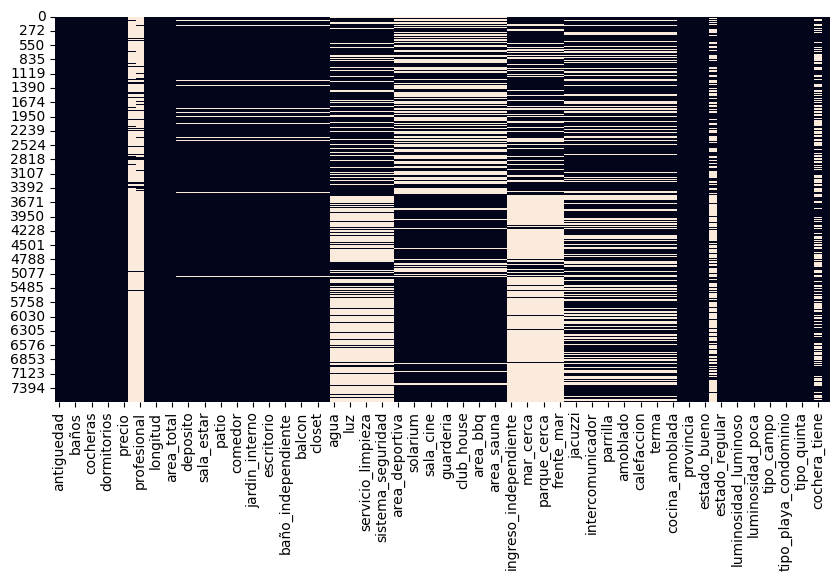

In [12]:
fig=plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

#### Matriz de Correlación

In [13]:
columnasFloat = df.select_dtypes(include=['float']).columns
columnasEnteras = df.select_dtypes(include=['int']).columns

# Concatenar las columnas numéricas y las columnas específicas
columnasSeleccionadas = list(columnasEnteras) + list(columnasFloat)
columnasSeleccionadas.remove('precio')
columnasSeleccionadas.insert(0, 'precio')


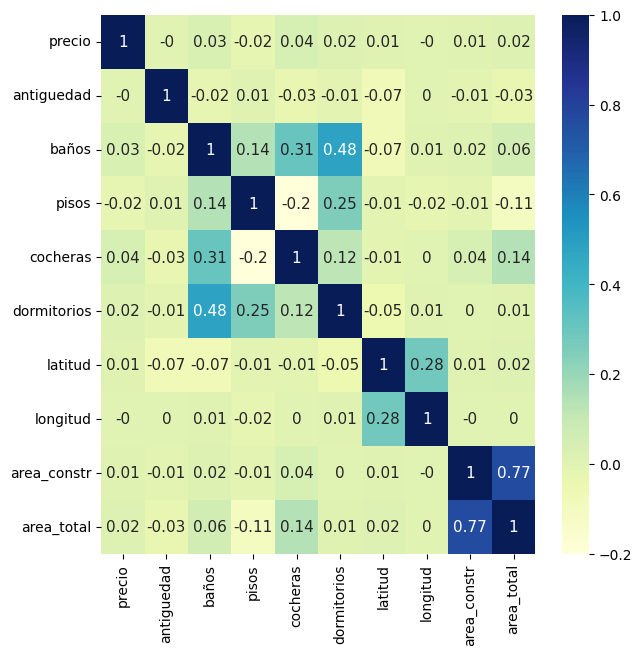

In [14]:
# Generamos un mapa de calor con las correlaciones de los datos
dfSeleccionado = df[columnasSeleccionadas]

corr =  dfSeleccionado.corr().round(2)
plt.figure(figsize=(7,7))
sns.heatmap(corr, cmap="YlGnBu", annot=True, annot_kws={"size": 11})
plt.show()


De la Matriz de Correlación podemos indicar lo siguiente:

- Si la correlación entre dos características es positiva, significa que a medida que una característica aumenta,
la otra tiende a aumentar también. Por ejemplo, si la vivienda tiene cocheras, entonces el precio de la casa también tienda a aumentar.

#### Análisis de Varianza (ANOVA)

In [15]:
# El análisis de varianza sirve para comparar las medias de grupos formados por las categorías de las variables categóricas en relación con el precio

# Filtrar columnas categóricas y el precio
columnas_categoricas = df.select_dtypes(include='category')
columna_precio = df[['precio']]

# Concatenar las columnas seleccionadas
data = pd.concat([columna_precio, columnas_categoricas], axis=1)

In [16]:
# Lista para almacenar los resultados del ANOVA
anovaResults = []

# Iteración de las columnas categóricas binarias
for column in data.columns:

   # Verifica si es binario
    if data[column].nunique() == 2:
        # Realiza el ANOVA
        formula = f"precio ~ {column}"
        model = sm.OLS.from_formula(formula, data=data)
        anova_result = sm.stats.anova_lm(model.fit())

        # Añade el resultado a la lista
        anovaResults.append((column, anova_result))

# Impresión de resultados
for column, result in anovaResults:

  if (result['PR(>F)'][0])<0.05:
    print(f"Análisis de Varianza para: {column}")
    print(result)
    print("\n")



Análisis de Varianza para: cuarto_servicio
                     df        sum_sq       mean_sq         F    PR(>F)
cuarto_servicio     1.0  3.440817e+14  3.440817e+14  7.240511  0.007145
Residual         6914.0  3.285653e+17  4.752174e+13       NaN       NaN


Análisis de Varianza para: sala_estar
                df        sum_sq       mean_sq         F    PR(>F)
sala_estar     1.0  1.837898e+14  1.837898e+14  3.865603  0.049325
Residual    6914.0  3.287256e+17  4.754492e+13       NaN       NaN


Análisis de Varianza para: comedor_diario
                    df        sum_sq       mean_sq         F    PR(>F)
comedor_diario     1.0  3.801261e+14  3.801261e+14  7.999871  0.004692
Residual        6914.0  3.285293e+17  4.751653e+13       NaN       NaN


Análisis de Varianza para: baño_servicio
                   df        sum_sq       mean_sq         F    PR(>F)
baño_servicio     1.0  3.281508e+14  3.281508e+14  6.904943  0.008615
Residual       6914.0  3.285812e+17  4.752404e+13       NaN 

Las columnas que tienen el valor valor p < 0.05 y asu vez estan más cerca al cero indican que existe evidencia estadística de que la variable categórica está relacionada con el precio. Las columnas que satisfacen esa condición y están mas cerca al cero son : chimenea,jacuzzi,aire_acondicionado,area_deportiva,hall_ingreso,areas_verdes,desague,piscina,sauna y area_bbq.

####  Distribución de Precios

In [17]:
# Excluir columnas de tipo 'object' del DataFrame
columnas_object = df.select_dtypes(include='object').columns
data = df.drop(columns=columnas_object)

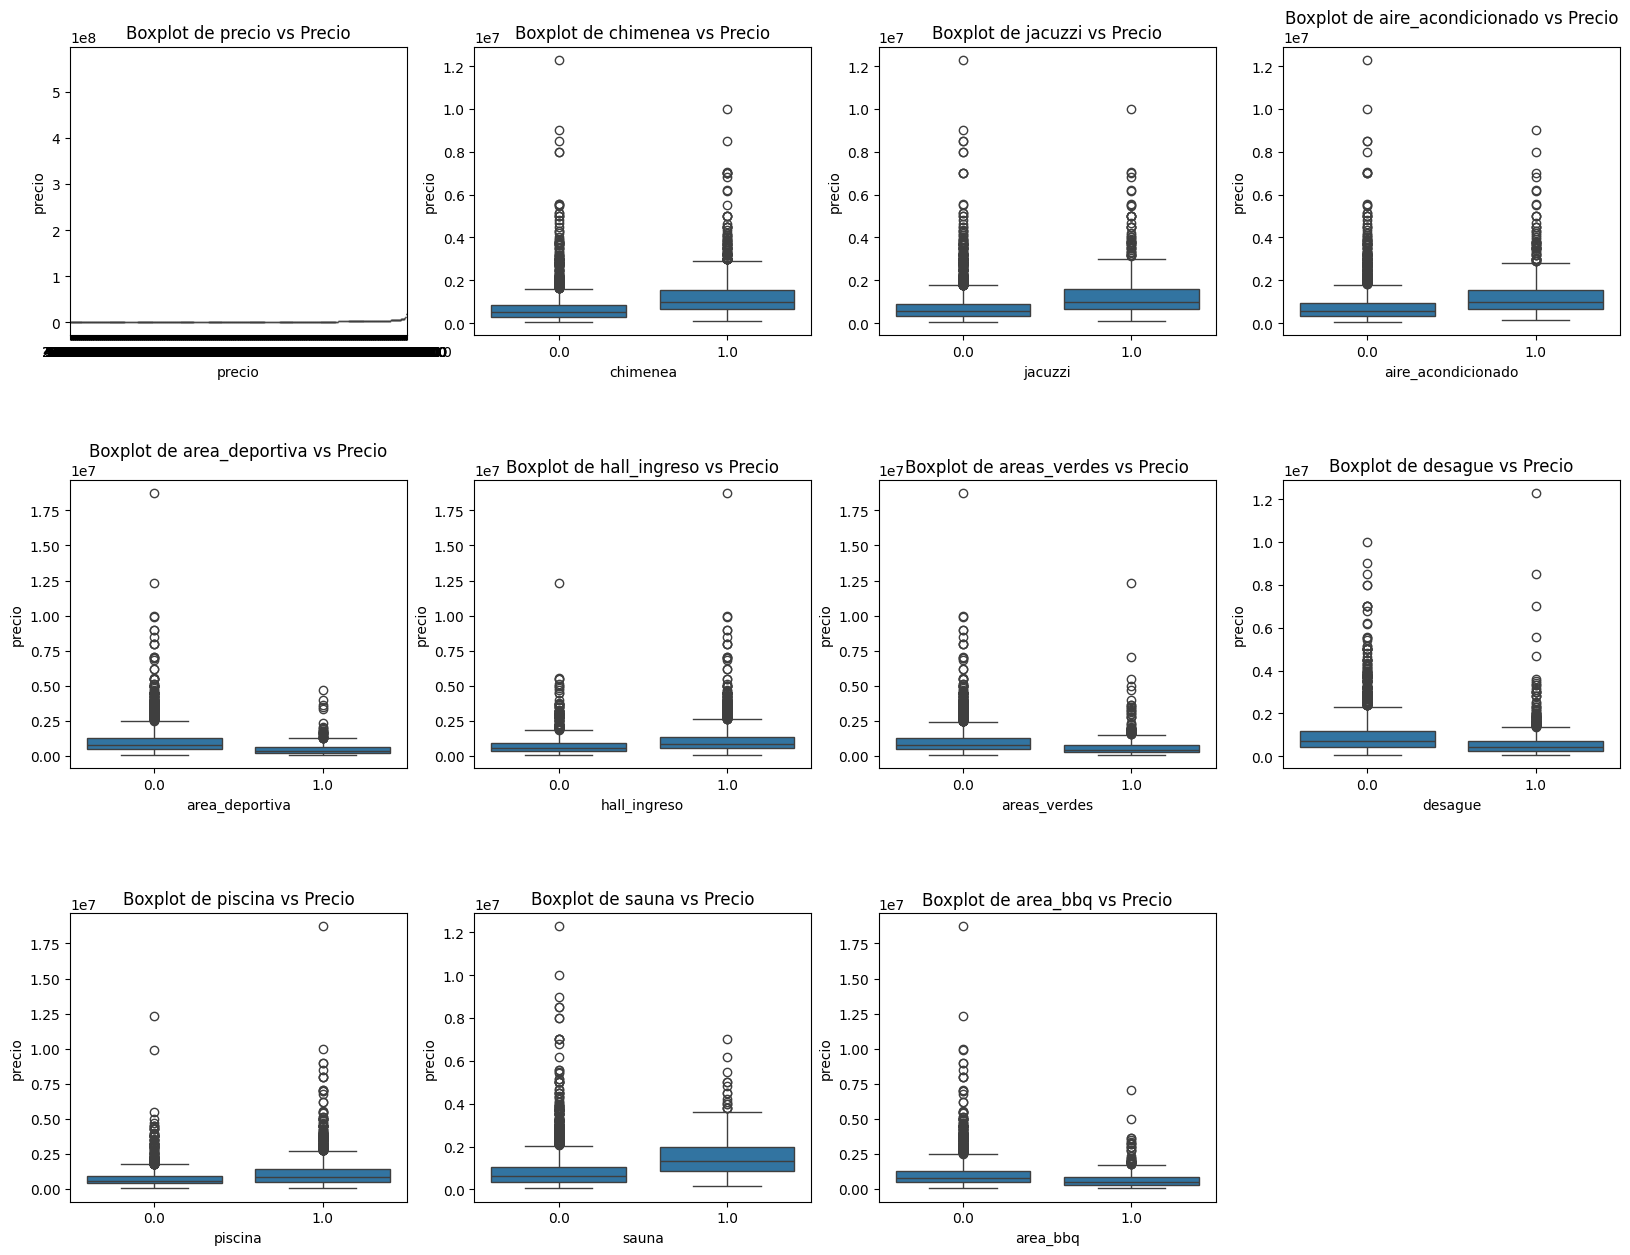

In [18]:
# las columnas a visualizar provienen de realizar el análisis de varianza ANOVA
dataHisto=data[['precio','chimenea','jacuzzi','aire_acondicionado','area_deportiva','hall_ingreso','areas_verdes','desague','piscina','sauna','area_bbq']]

nom_cols = dataHisto.columns.to_numpy()
plt.figure(figsize=(20,15))
i = 1
plt.subplots_adjust(hspace=0.5)

for col in list(nom_cols):
    plt.subplot(len(nom_cols)//4+1,4,i)

    #  Eliminar filas con NaN en la columna específica
    dfSeleccionado = dataHisto.dropna(subset=[col])

    sns.boxplot(data=dfSeleccionado, y = 'precio',x = col)
    plt.title(f'Boxplot de {col} vs Precio')
    i+=1
plt.show()

- Utilizamos boxplots para visualizar cómo se distribuyen los precios con cada característica.
- Se reconoce que hay una diferencia clara en las posiciones de las medianas entre los valores categóricos de cada caraterítica.
- Se tiene un precio más alto cuando existe la presencia de chimenea,jacuzzi, aire_acondicionado,hall_ingreso, piscina y sauna.

#### Gráfico de Histograma de las columnas

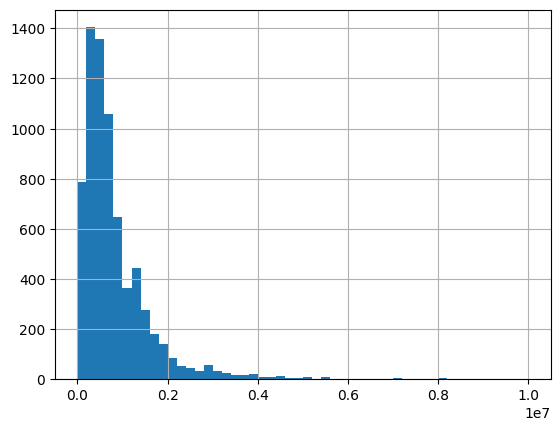

<Figure size 1000x600 with 0 Axes>

In [19]:
#Distibución de la variable objetivo precio
df.precio.hist(bins = 50, range=(0, 1e7))
plt.figure(figsize=(10, 6))
plt.show()

De acuerdo al gráfico se puede indicar lo siguiente:

- La distribución se apila al lado izquierdo y tiene una "cola" alargada a la derecha, por lo que es claro que la distribución es sesgada a la derecha.
- La gran mayoría de los precios de las casas son de 4 Millones de soles o menos.
- La distribución es claramente unimodal, ya que un pico del precio ocurre en entre 0 y  0.8 Milllones soles.
- Existe un dato extremadamente atípico sucede en alrededor de un precio de 8 Millones de soles.


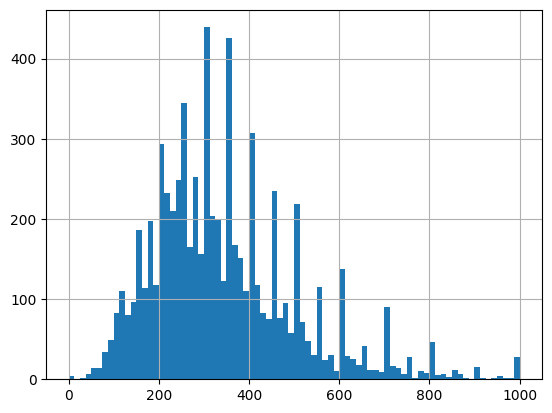

<Figure size 1000x600 with 0 Axes>

In [20]:
#Distibución de la columna area de construccion
df.area_constr.hist(bins = 80, range=(0, 1e3))
plt.figure(figsize=(10, 6))
plt.show()

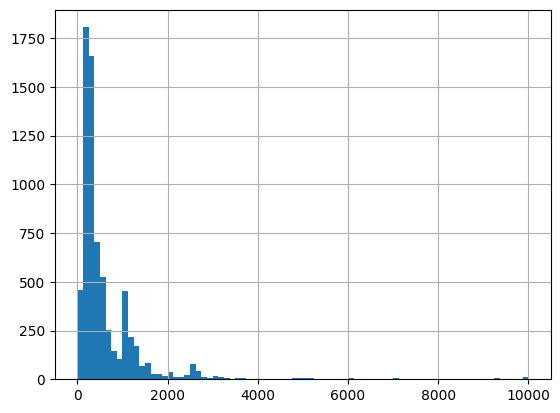

<Figure size 1000x600 with 0 Axes>

In [21]:
#Distibución de la columna area de construccion
df.area_total.hist(bins = 80, range=(0, 1e4))
plt.figure(figsize=(10, 6))
plt.show()

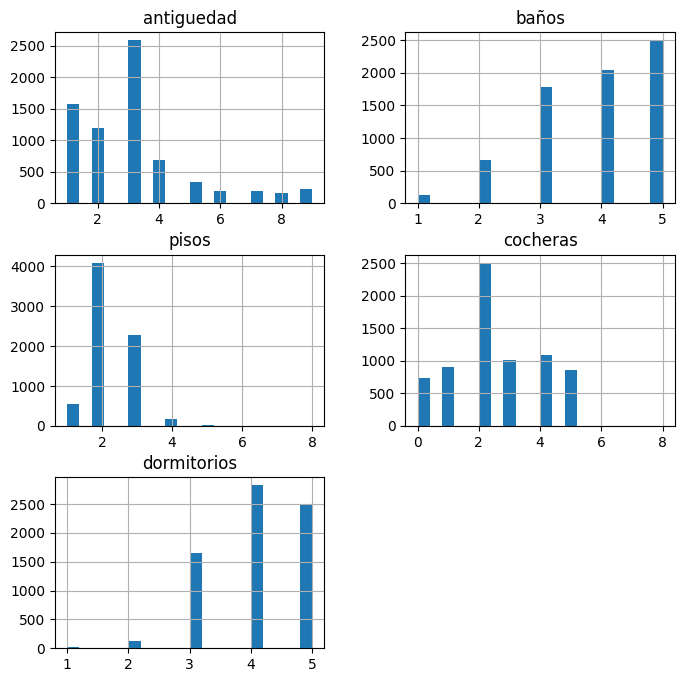

In [22]:
#Gráfico de histogramas de las columnas numéricas
columnasSeleccionadas.remove('precio')
columnasSeleccionadas.remove('area_constr')
columnasSeleccionadas.remove('area_total')
columnasSeleccionadas.remove('latitud')
columnasSeleccionadas.remove('longitud')

dfNumericas = df[columnasSeleccionadas]


dfNumericas.hist(bins = 20, figsize= (8,8))
plt.show()

De estas gráficas podemos decir lo siguiente:

- Tiene más frecuencia encontar una vivienda con 3 años de antigüedad, con 5 baños, que tenga 2 pisos, 2 cocheras, 4 dormitorios.

- La presencia de viviendas con 8 años de antiguedad, con 1 baño, de 5 pisos, sin cochera y de un dormitorio son las que tienen las frencuencias más bajas que podemos encontrar.





#### Distribución de Viviendas por Distrito

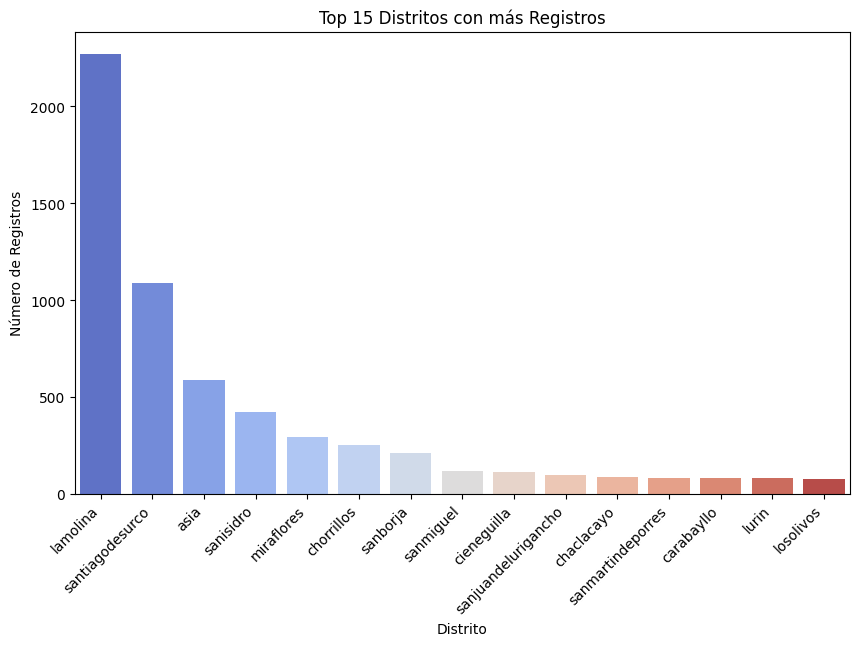

In [23]:
# Obtener la cuenta de registros por distrito
conteoDistritos = df['distrito'].value_counts()

# Seleccionar los 10 distritos con más registros
topDistritos = conteoDistritos.head(15)


# Crear la gráfica de barras en orden descendente
plt.figure(figsize=(10, 6))

sns.barplot(x=topDistritos.index, y=topDistritos.values, palette='coolwarm')

plt.title('Top 15 Distritos con más Registros')
plt.xlabel('Distrito')
plt.ylabel('Número de Registros')
plt.xticks(rotation=45, ha='right')
plt.show()


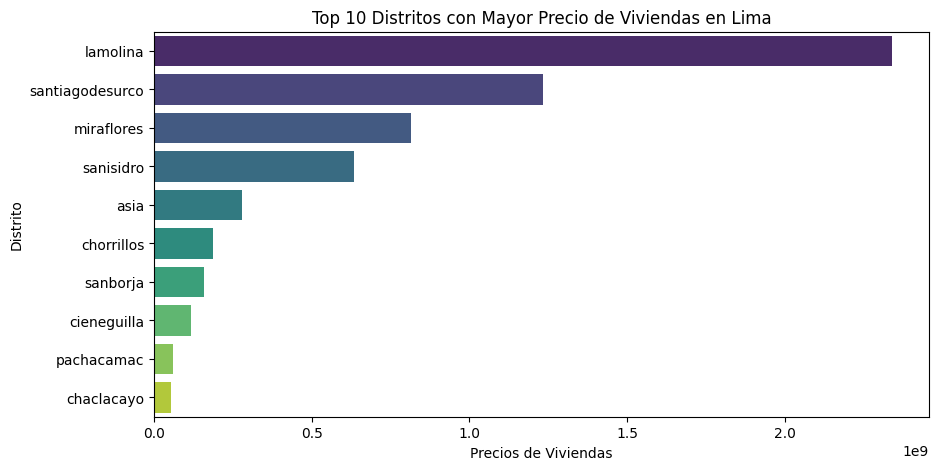

In [24]:
# Cálculo de la suma acumulada de precios por distrito y selecciona el top 10
topDistritos = df.groupby('distrito')['precio'].sum().sort_values(ascending=False).head(10).index
dataTop10 = df[df['distrito'].isin(topDistritos)]

# Ajusta el tamaño de la figura
plt.figure(figsize=(10, 5))

# Udo del gráfico de barras horizontal con la suma acumulada de precios
sns.barplot(x=dataTop10.groupby('distrito')['precio'].sum().sort_values(ascending=False).values,
            y=dataTop10.groupby('distrito')['precio'].sum().sort_values(ascending=False).index,
            ci=None, palette="viridis")

# Etiquetas y título
plt.xlabel('Precios de Viviendas')
plt.ylabel('Distrito')
plt.title('Top 10 Distritos con Mayor Precio de Viviendas en Lima')

# Muestra el gráfico
plt.show()



#### Distribución de Viviendas por Tipo

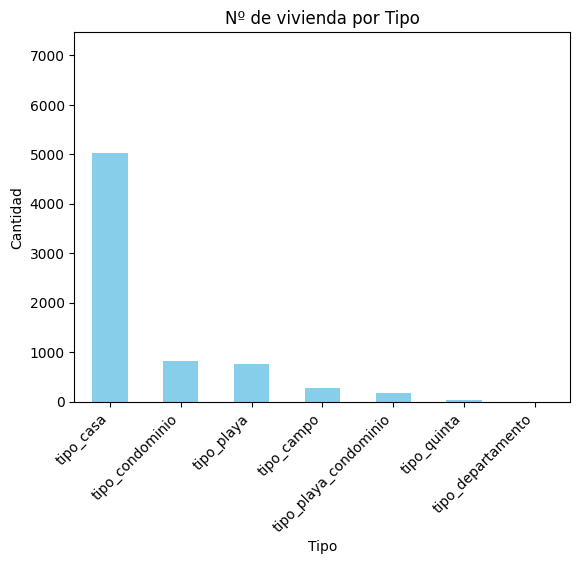

In [25]:
# Solo las columnas que comienzan con "tipo_"
columnas_tipo = df.filter(like="tipo_")

# Filtro de filas donde al menos una columna tiene valor igual a 1
columnas_tipo_filtradas = columnas_tipo[columnas_tipo.eq(1).any(axis=1)]

# Cálculo la frecuencia de valores igual a 1 en las columnas seleccionadas
frecuencia_valores = columnas_tipo_filtradas.apply(lambda x: x.eq(1).value_counts().reindex([False, True])).T

# Invertir el orden de las columnas en el DataFrame
frecuencia_valores = frecuencia_valores.iloc[:, ::-1]


# Gráfico de barras
frecuencia_valores = frecuencia_valores.sort_values(by=True, ascending=False)
frecuencia_valores.plot(kind="bar", stacked=True, color=["skyblue", "white"], legend=False)

# Etiquetas y título
plt.xlabel("Tipo")
plt.ylabel("Cantidad")
plt.title("Nº de vivienda por Tipo")

# Diseño para mostrar todas las etiquetas del eje x
plt.xticks(rotation=45, ha="right")

plt.show()

#### Ubicacion de las Zonas de las Viviendas en Lima

In [26]:
# Creación de un objeto geolocalizador de Nominatim (servicio de geocodificación de OpenStreetMap)
geolocator = Nominatim(user_agent="my_geocoder")

# Obtención de coordenadas aproximadas para el centro de Lima
centro_coords = geolocator.geocode("Lima, Peru").latitude, geolocator.geocode("Lima, Peru").longitude

# Obtención de coordenadas aproximadas para otras áreas (ajusta según tus necesidades)
norte_coords = geolocator.geocode("Lima Norte, Peru").latitude, geolocator.geocode("Lima Norte, Peru").longitude
este_coords = geolocator.geocode("Lima Este, Peru").latitude, geolocator.geocode("Lima Este, Peru").longitude
oeste_coords = geolocator.geocode("Lima Oeste, Peru").latitude, geolocator.geocode("Lima Oeste, Peru").longitude
sur_coords = geolocator.geocode("Lima Sur, Peru").latitude, geolocator.geocode("Lima Sur, Peru").longitude

print("Centro:", centro_coords)
print("Norte:", norte_coords)
print("Este:", este_coords)
print("Oeste:", oeste_coords)
print("Sur:", sur_coords)


Centro: (-12.0621065, -77.0365256)
Norte: (-11.9236997, -76.6808301)
Este: (-12.0874728, -77.00478757688256)
Oeste: (-11.879433, -77.1331711)
Sur: (-12.239097950000001, -76.91195411343624)


In [27]:
# Diccionario de ubicaciones
ubicacion = {
    "Centro": [-12.0621065, -77.0365256],
    "Norte": [-11.9236997, -76.6808301],
    "Este" : [-12.069716849999999, -76.9488436628052],
    "Oeste":[-11.879433, -77.1331711],
    "Sur": [-12.239097950000001, -76.91195411343624]
}

# Función para encontrar la ubicación más cercana
def encontrar_ubicacion(lat, lon):
    punto_actual = (lat, lon)
    ubicacion_mas_cercana = min(ubicacion.keys(), key=lambda key: geodesic(punto_actual, ubicacion[key]).km)
    return ubicacion_mas_cercana

# Aplicación de la función para crear la nueva columna 'ubicacion'
df['ubicacion'] = df.apply(lambda row: encontrar_ubicacion(row['latitud'], row['longitud']), axis=1)


#### Distribución de la cantidad de Viviendas en Lima por Zonas

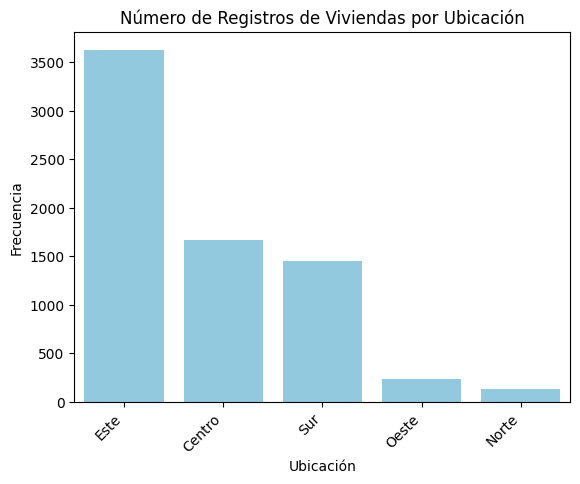

In [28]:
# Crear el gráfico de conteo con Seaborn
sns.countplot(data=df, x="ubicacion", order=df['ubicacion'].value_counts().index, color='skyblue')

# Agregar etiquetas y título
plt.xlabel('Ubicación')
plt.ylabel('Frecuencia')
plt.title('Número de Registros de Viviendas por Ubicación')

# Rotar las etiquetas del eje x para una mejor visualización
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.show()


#### Distrubución de Viviendas por Precio Promedio

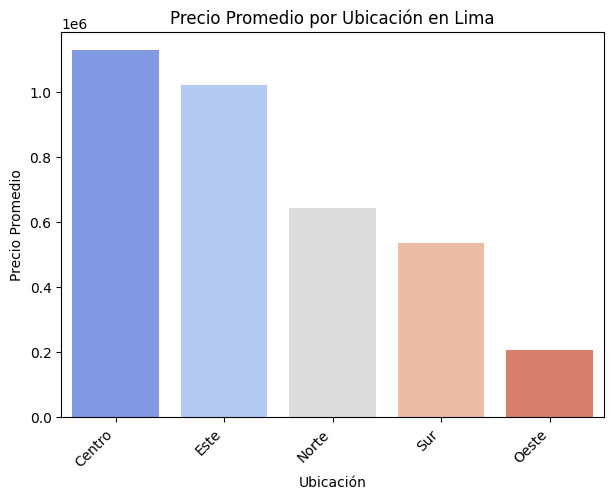

In [29]:
precio_area = df.groupby('ubicacion')['precio'].mean().sort_values(ascending=False)

# Creación del gráfico de barras utilizando Seaborn
plt.figure(figsize=(7, 5))


sns.barplot(x=precio_area.index, y=precio_area.values, palette='coolwarm')

# Etiquetas y título
plt.xlabel('Ubicación')
plt.ylabel('Precio Promedio')
plt.title('Precio Promedio por Ubicación en Lima')

# Rotación de las etiquetas del eje x para una mejor visualización
plt.xticks(rotation=45, ha='right')

plt.show()

#### Distribución de Antigüedad por Ubicación - Histograma

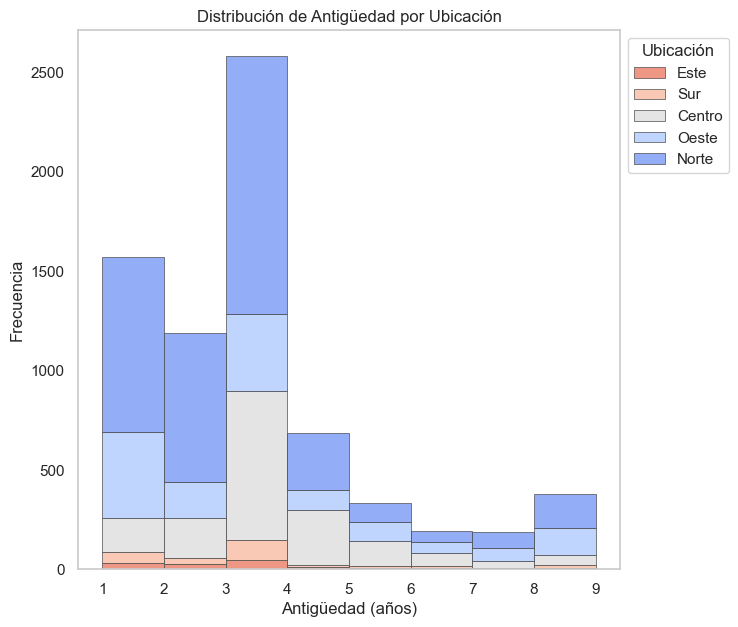

In [30]:
#Histograma: Muestra la cantidad absoluta de viviendas en cada bin

#Estilo de Seaborn
sns.set(style="whitegrid")

# Gráfica del histograma
plt.figure(figsize=(7, 7))
ax = sns.histplot(data=df, x="antiguedad", hue="ubicacion", binwidth=1, palette="coolwarm", multiple="stack", edgecolor=".3", linewidth=.5, legend=True)

# Eliminar líneas horizontales y verticales en el fondo del gráfico
ax.yaxis.grid(False)
ax.xaxis.grid(False)

# Título y etiquetas
plt.title('Distribución de Antigüedad por Ubicación')
plt.xlabel('Antigüedad (años)')
plt.ylabel('Frecuencia')

# Leyenda
ax.legend(title='Ubicación', bbox_to_anchor=(1, 1), loc='upper left', labels=df['ubicacion'].unique())

# Mostrar la gráfica
plt.show()


La gráfica muestra cómo se distribuyen las antigüedades de las viviendas en diferentes ubicaciones. Se puede visualizar que predominan las viviendas ubicadas en Lima Norte que poseen una antigüedad en el rango de 1 a 4 años.

####  Distribución de Antigüedad por Ubicación - Gráfico de densidad kernel

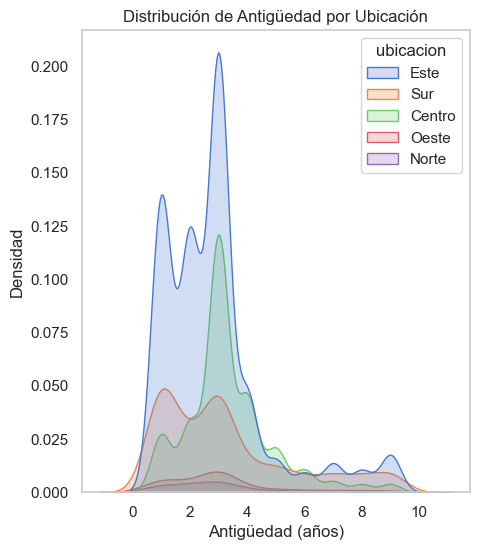

In [31]:
#Gráfico de densidad kernel: Muestra la distribución relativa de la probabilidad de antigüedad en comparación con otras ubicaciones.

# Filtrar NaN en 'antiguedad'
df_filtered = df.dropna(subset=['antiguedad'])

# Verificar y convertir 'antiguedad' a tipo entero
df_filtered['antiguedad'] = df_filtered['antiguedad'].astype(int)

# Elegir una paleta de colores más distintiva
palette = "muted"

plt.figure(figsize=(5, 6))

# Crear gráfico KDE con la paleta seleccionada
ax= sns.kdeplot(data=df_filtered, x="antiguedad", hue="ubicacion", fill=True, palette=palette)

# Eliminar líneas horizontales y verticales en el fondo del gráfico
ax.yaxis.grid(False)
ax.xaxis.grid(False)

# Añadir título y etiquetas
plt.title('Distribución de Antigüedad por Ubicación')
plt.xlabel('Antigüedad (años)')
plt.ylabel('Densidad')

# Mostrar  gráfico
plt.show()


-En el rango de 1 a 4 años la curva es más baja para el Norte, significa que hay una menor probabilidad de encontrar viviendas de esa antigüedad en el Norte en comparación con las otras ubicaciones.

-En el rango de 1 a 4 años, si la curva es más alta para el Este, significa que, en términos relativos, hay una mayor probabilidad de encontrar viviendas con esa antigüedad en esa zona.

#### Localización de las Viviendas a partir de la latitud y longitud

In [32]:
dataLocalizacion = df[df['latitud'].notnull()]
dataLocalizacion = dataLocalizacion[dataLocalizacion['longitud'].notnull()]

lat_lon_pairs = list(zip(list(dataLocalizacion.latitud), list(dataLocalizacion.longitud)))

#Usando Folium para generar un mapa simple a partir de los datos de Localización
map = folium.Map(location=[-12.0464, -77.0428], zoom_start=12)
HeatMap(lat_lon_pairs).add_to(map)

map